# Imports

In [1]:
!pip install -U nltk
!pip install regex
import nltk
nltk.download("all")

     |████████████████████████████████| 1.5 MB 4.4 MB/s 
     |████████████████████████████████| 749 kB 46.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [2]:
import re
import nltk
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords,wordnet
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Dense,LSTM,Activation,Embedding,Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("/content/data/W14_HW_Airline_Tweets.xlsx - H4_Airline_Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
0,570306133677760000,neutral,1.0000,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,570301130888122000,positive,0.3486,NaN,0.0000,Virgin America,@VirginAmerica plus you've added commercials t...
2,570301083672813000,neutral,0.6837,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624000,negative,1.0000,Bad Flight,0.7033,Virgin America,@VirginAmerica it's really aggressive to blast...
4,570300817074462000,negative,1.0000,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...


In [5]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

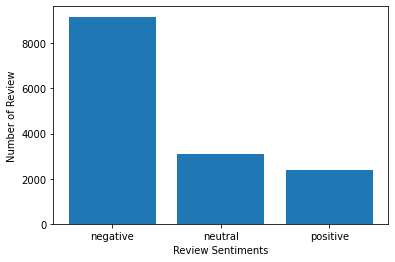

In [6]:
sentiment_count=df.groupby('airline_sentiment').count()
plt.bar(sentiment_count.index.values, sentiment_count["text"])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

From observation, data is skewed towards negative reviews

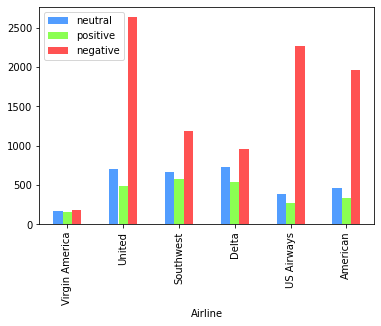

In [49]:
rank = df.groupby(["airline", "airline_sentiment"]).size()
airlines = df["airline"].unique()
sentiments = df["airline_sentiment"].unique()
rank_df = pd.DataFrame([[airline] + [rank[airline, sentiment] for sentiment in sentiments] for airline in airlines], columns=["Airline"] + sentiments.tolist())
rank_df.plot(
    x="Airline",
    kind="bar",
    stacked=False,
    color=['#529dff','#8bff52','#ff5252']
)

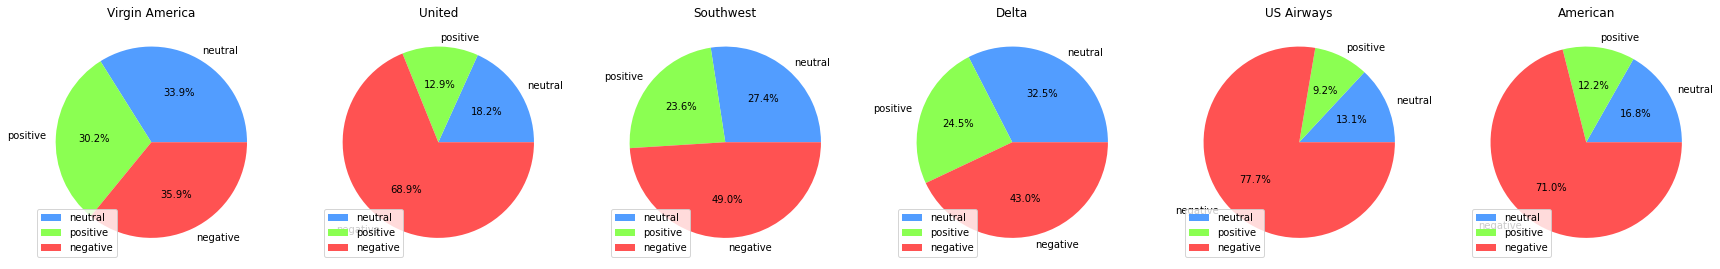

In [48]:
fig, axs = plt.subplots(1,len(airlines),figsize=(30,30))
for idx, ax in enumerate(axs):
  ax.pie([rank_df.iloc[idx][sentiment] for sentiment in sentiments], autopct="%.1f%%", labels=sentiments, colors=['#529dff','#8bff52','#ff5252'])
  ax.legend(loc="lower left")
  ax.set_title(airlines[idx])

# Preprocessing

In [124]:
vocab_size = 50000  # Only consider the top 50k words
maxlen = 100 # Only first 100 words of each record

In [92]:
sentiments = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

In [50]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [94]:
def text_cleaning(text):
    stop_word = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        # \ Signals a special sequence (can also be used to escape special characters)
        text = re.sub('\/',' ',text)
        # "r" in the beginning is making sure that the string is being treated as a "raw string"
        text = re.sub(r'\\',' ',text)
        # \S the string DOES NOT contain a white space character
        text = re.sub(r'((http)\S+)',' ',text)
        # remove twitter handle
        text = re.sub(r'@\w+','',text)
        # \s the string contains a white space character
        # [^A-Za-z] a match for any character EXCEPT any character alphabetically between a and z, lower case OR upper case
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        # \W where the string DOES NOT contain any word characters (characters from a to Z, digits from 0-9, and the underscore _ character)
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in stop_word]
        text=[nltk.WordNetLemmatizer().lemmatize(word,get_wordnet_pos(word)) for word in text]
        return text
    return []

In [95]:
df_1=df.copy()
df_1['text'] = df_1['text'].apply(lambda x: ' '.join(text_cleaning(x)))
phrases = df_1['text'].tolist()
encoded_phrases = [one_hot(d, vocab_size) for d in phrases]
df_1['text'] = encoded_phrases
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(df_1['text'], df['airline_sentiment'].map(sentiments), test_size=0.3, random_state=42)

In [110]:
X_train_lstm = keras.preprocessing.sequence.pad_sequences(X_train_lstm, maxlen=maxlen)
X_test_lstm = keras.preprocessing.sequence.pad_sequences(X_test_lstm, maxlen=maxlen)

# Model

In [125]:
model = Sequential([
                    Embedding(input_dim=vocab_size, output_dim=256, input_length=maxlen),
                    Bidirectional(LSTM(128, return_sequences=True)),
                    Bidirectional(LSTM(128)),
                    Dense(3, activation="sigmoid")
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 256)          12800000  
                                                                 
 bidirectional_10 (Bidirecti  (None, 100, 256)         394240    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 13,589,251
Trainable params: 13,589,251
Non-trainable params: 0
_________________________________________________________________


In [126]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=2, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/2
321/321 [==============================] - 46s 114ms/step - loss: 0.6514 - accuracy: 0.7273 - val_loss: 0.5464 - val_accuracy: 0.7807
Epoch 2/2
321/321 [==============================] - 35s 108ms/step - loss: 0.4152 - accuracy: 0.8348 - val_loss: 0.5458 - val_accuracy: 0.7869


In [140]:
y_test_lstm

4794     2
10480    0
8067     0
8880     1
8292     0
        ..
12156    2
6518     1
2245     0
4165     0
11671    0
Name: airline_sentiment, Length: 4392, dtype: int64

In [154]:
y_pred_lstm = pd.Series(np.argmax(model.predict(X_test_lstm), axis=1), index=y_test_lstm.index)
y_pred_lstm

4794     2
10480    0
8067     0
8880     1
8292     0
        ..
12156    2
6518     2
2245     0
4165     0
11671    0
Length: 4392, dtype: int64

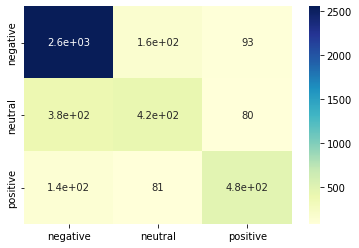

In [162]:
cf = confusion_matrix(y_test_lstm, y_pred_lstm)
labels = ["negative", "neutral", "positive"]
sns.heatmap(cf, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)